In [34]:
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import rcParams
import matplotlib.font_manager as font_manager
from PIL import Image, ImageDraw, ImageFont

#from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.inception_v3 import preprocess_input
#from keras.utils.data_utils import GeneratorEnqueuer
import math

#mpl.rc('font', family='TakaoPGothic')
rcParams['axes.unicode_minus']=False

In [36]:
fontsize = 50

# From https://www.google.com/get/noto/
#!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
#!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
#!rm NotoSansCJKjp-hinted.zip

path = './NotoSansCJKjp-Regular.otf'
prop = font_manager.FontProperties(fname=path)

In [3]:
#Save all the paths to vars
input_dir = Path("../kuzushiji_data")
#test_dir = input_dir/'test_images'
train_dir = input_dir/'train_images'

In [4]:
#Check out all the folders
print(os.listdir(input_dir))
#print(os.listdir(test_dir)[:5])
print(os.listdir(train_dir)[:5])

['.DS_Store', 'unicode_translation.csv', 'train.csv', 'train_images', 'sample_submission.csv']
['200021712-00072_1.jpg', '200021851_00019_2.jpg', '200003076_00120_2.jpg', '200021712-00037_1.jpg', 'brsk005-005.jpg']


In [5]:
#Check the number of training and testing images
#print(len(os.listdir(test_dir)))
print(len(os.listdir(train_dir)))

3881


In [6]:
#Inspect train.csv
train_df = pd.read_csv(input_dir/'train.csv')
train_df.head(n=10)

image_id                                             labels
0  100241706_00004_2  U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1  100241706_00005_1  U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2  100241706_00005_2  U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3  100241706_00006_1  U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4  100241706_00007_2  U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...
5  100241706_00008_1  U+25B2 1056 929 96 39 U+309D 379 1098 21 43 U+...
6  100241706_00008_2  U+25B2 1648 955 95 44 U+25B2 1887 947 96 45 U+...
7  100241706_00009_1  U+3078 1551 2071 104 41 U+3078 323 1473 135 43...
8  100241706_00009_2  U+309D 1452 1423 20 37 U+3078 690 2535 121 41 ...
9  100241706_00010_1  U+3078 587 1127 100 40 U+3064 1103 1480 60 45 ...

In [7]:
#inspect unicode_translation.csv
unicode_df = pd.read_csv(input_dir/'unicode_translation.csv')
unicode_df.tail(n=10)

Unicode char
4777  U+FA3F    憎
4778  U+FA45    海
4779  U+FA4A    琢
4780  U+FA4E    祈
4781  U+FA55    突
4782  U+FA5C    臭
4783  U+FA65    贈
4784  U+FA68    難
4785  U+FF0D    －
4786  U+FF2F    Ｏ

In [8]:
print(len(unicode_df))

4787


In [9]:
def toPath(string):
    if ".jpg" not in string:
        string = string + ".jpg"
    return string

def toID(string):
    if string[-4:] ==".jpg":
        string = string[:-4]
    return string

def displayImage(image):
    plt.figure(figsize=(15,15))
    this_img = Image.open(train_dir/toPath(image))
    plt.imshow(this_img)
    return plt

<module 'matplotlib.pyplot' from '/Users/fanliu/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

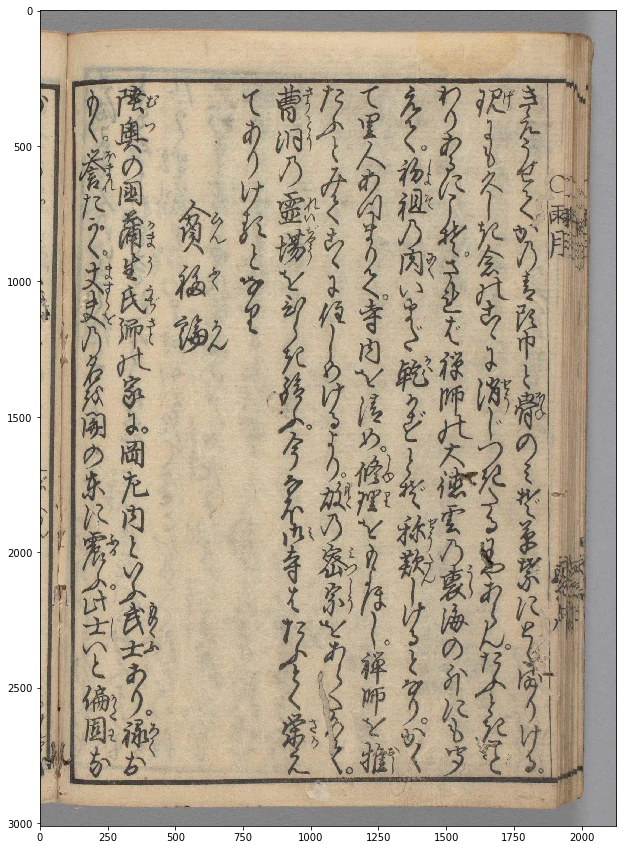

In [20]:
rnd_nbr = random.randint(0,len(os.listdir(train_dir)))
rnd_img_path = os.listdir(train_dir)[rnd_nbr]
displayImage(rnd_img_path)

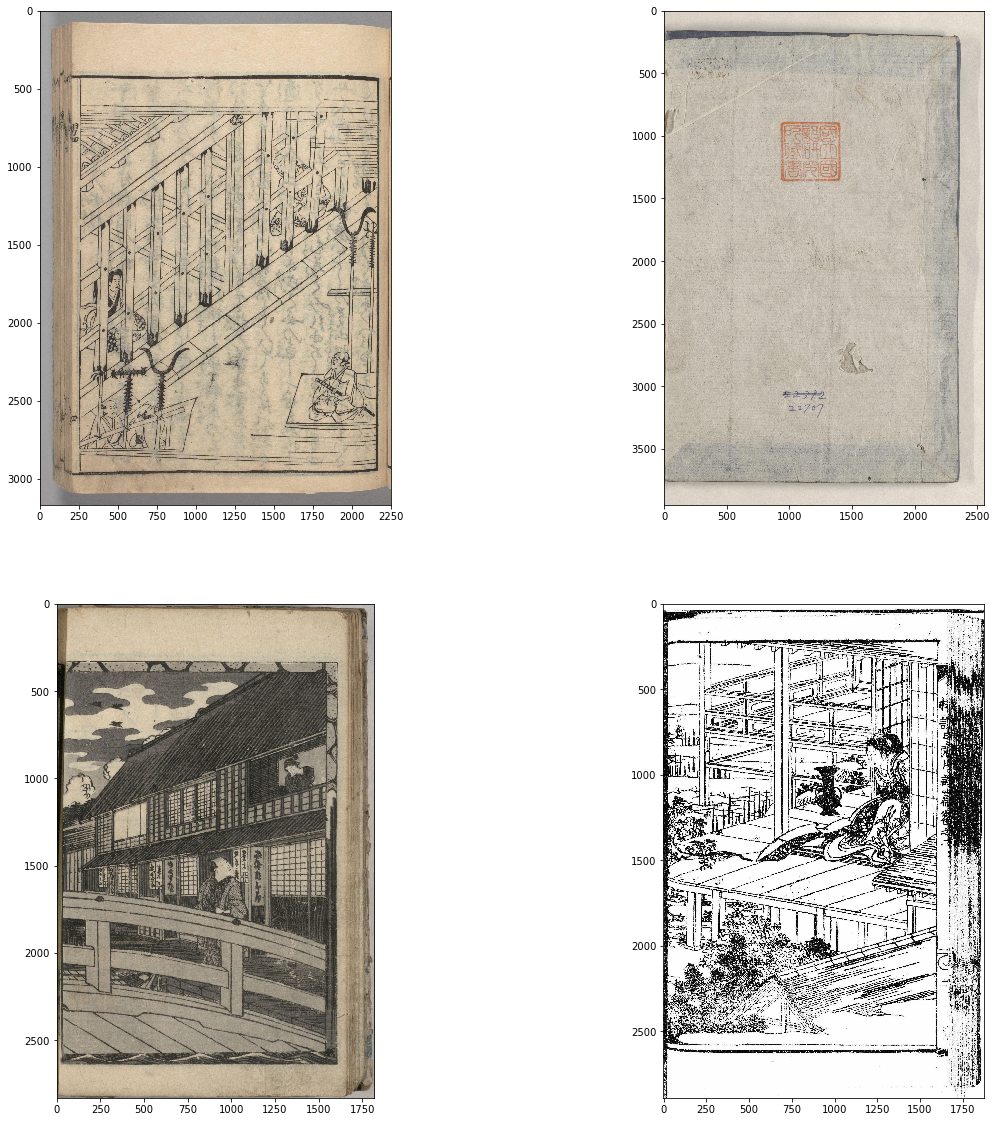

In [26]:
# checkout NaN column in training images
images_nan_labels = train_df[train_df.isnull()['labels']]['image_id'].tolist()

rows = 2
columns = 2
fig = plt.figure(figsize=(20, 20))

for i in range(1, rows*columns + 1):
    rnd_img_nan_nbr = random.randint(0, len(images_nan_labels)-1)
    img_nan = Image.open(train_dir/toPath(images_nan_labels[rnd_img_nan_nbr]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_nan, aspect='equal')
    
plt.show()

In [10]:
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(input_dir/'unicode_translation.csv').values}
unicode_list = list(unicode_map)

def unicodeToCharacter(unicode):
    return unicode_map[unicode]

# unicode to int conversion and the other way around
# unique identifier for every unicode character
def unicodeToInt(unicode):
    return unicode_list.index(unicode)

def intToUnicode(integer):
    return unicode_list[integer]

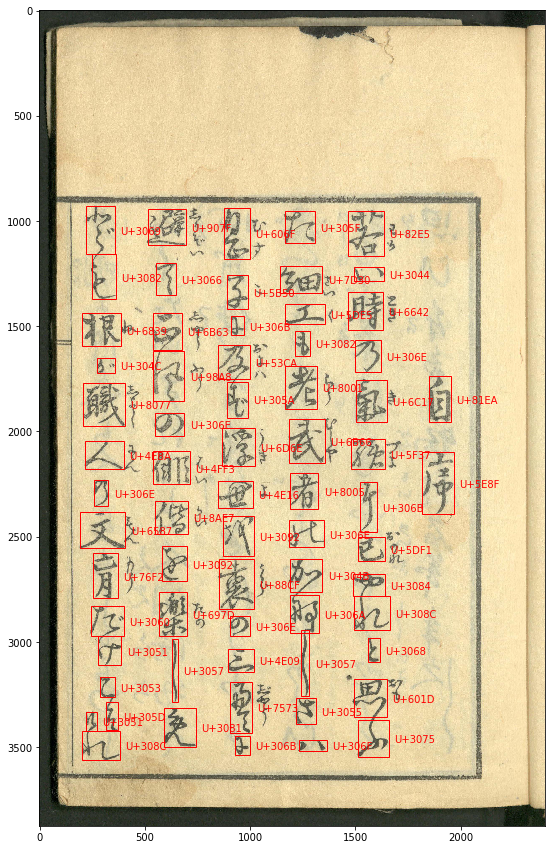

In [42]:
# take the image_id return an image with bounding boxes around each character
# image_id is the filename without the file extension (in this case .jpg)
image_id = "100241706_00004_2"

# get all the characters and the position of the bounding boxes for an image
def getLabels(image_id):
    allLabels = train_df.loc[train_df["image_id"]==image_id, 'labels'][0]
    allLabels = np.array(allLabels.split(" ")).reshape(-1, 5)
    return allLabels

def drawBoxAndText(ax, label):
    codepoint, x, y, w, h = label
    x, y, w, h = int(x), int(y), int(w), int(h)
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(x+w+25, y+(h/2)+20, codepoint,
            color="r",size=10)
    return ax

def displayTrainingData(image_id):
    labels = getLabels(image_id)
    plt = displayImage(image_id)
    #plt.rcParams['font.family'] = font_manager.FontProperties(fname=path).get_name()
    ax = plt.gca()

    for label in labels:
        ax = drawBoxAndText(ax, label)
        
    
displayTrainingData(image_id)

In [39]:
mpl.matplotlib_fname()

'/Users/fanliu/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'